In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Base SIM_DOFET

In [3]:
df_sim = pd.read_csv('./base_limpa/base_sim_dofet_limpa_remocao.csv')

In [4]:
df_sim_agreg_regiao = pd.DataFrame(
    df_sim.groupby(['cat_periodo_nasc', 'cat_peso_calc', 'ocor_REGIAO']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [5]:
# Removendo covid e zika
df_sim_agreg_regiao_covid_zika = pd.DataFrame(
    df_sim[~df_sim['ano_obito'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc', 'ocor_REGIAO']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [6]:
df_sim_agreg_brasil = pd.DataFrame(
    df_sim.groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [7]:
# Removendo covid e zika
df_sim_agreg_brasil_covid_zika = pd.DataFrame(
    df_sim[~df_sim['ano_obito'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [8]:
del df_sim

# Base SINASC

In [10]:
df_sinasc = pd.read_csv('./base_limpa/base_sinasc_limpa_remocao.csv')

In [11]:
df_sinasc_agreg_regiao = pd.DataFrame(
    df_sinasc.groupby(['cat_periodo_nasc', 'cat_peso_calc', 'nasc_REGIAO']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [12]:
# Removendo covid e zika
df_sinasc_agreg_regiao_covid_zika = pd.DataFrame(
    df_sinasc[~df_sinasc['ano_nasc'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc', 'nasc_REGIAO']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [13]:
df_sinasc_agreg_brasil = pd.DataFrame(
    df_sinasc.groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [14]:
# Removendo covid e zika
df_sinasc_agreg_brasil_covid_zika = pd.DataFrame(
    df_sinasc[~df_sinasc['ano_nasc'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [15]:
del df_sinasc

# Cálculos todos os anos 

In [17]:
def calculate_rr(df_obito, df_nasc, region=None):
    if region:
        df_obito = df_obito[df_obito['ocor_REGIAO'] == region].reset_index(drop=True)
        df_nasc = df_nasc[df_nasc['nasc_REGIAO'] == region].reset_index(drop=True)
    
    df_obito['group'] = 'Termo_AIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'termo') & (df_obito['cat_peso_calc'] == 'PIG'), 'group'] = 'Termo_PIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'AIG'), 'group'] = 'Pre_Termo_AIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'PIG'), 'group'] = 'Pre_Termo_PIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'termo') & (df_obito['cat_peso_calc'] == 'GIG'), 'group'] = 'Termo_GIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'GIG'), 'group'] = 'Pre_Termo_GIG'
    
    df_nasc['group'] = 'Termo_AIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'termo') & (df_nasc['cat_peso_calc'] == 'PIG'), 'group'] = 'Termo_PIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'AIG'), 'group'] = 'Pre_Termo_AIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'PIG'), 'group'] = 'Pre_Termo_PIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'termo') & (df_nasc['cat_peso_calc'] == 'GIG'), 'group'] = 'Termo_GIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'GIG'), 'group'] = 'Pre_Termo_GIG'
    
    deaths = df_obito.groupby('group')['Tamanho'].sum()
    births = df_nasc.groupby('group')['Tamanho'].sum()
    
    rr_results = []
    comparisons = [
        ('Termo_AIG', 'Termo_PIG'),
        ('Termo_AIG', 'Pre_Termo_AIG'),
        ('Termo_AIG', 'Pre_Termo_PIG'),
        ('Termo_AIG', 'Termo_GIG'),
        ('Termo_AIG', 'Pre_Termo_GIG')
    ]
    
    for ref, exp in comparisons:
        if ref in deaths and exp in deaths and ref in births and exp in births:
            rate_exp = deaths[exp] / births[exp]
            rate_ref = deaths[ref] / births[ref]
            rr = rate_exp / rate_ref
            
            ci_lower = rr * np.exp(-1.96 * np.sqrt((1/deaths[exp]) + (1/deaths[ref])))
            ci_upper = rr * np.exp(1.96 * np.sqrt((1/deaths[exp]) + (1/deaths[ref])))
            
            rr_results.append({
                'Region': region if region else 'Brasil',
                'Comparison': f'{exp} vs {ref}',
                'RR': round(rr, 2),
                'CI Lower': round(ci_lower, 2),
                'CI Upper': round(ci_upper, 2)
            })
    
    return pd.DataFrame(rr_results)


In [18]:
df_brasil_geral = calculate_rr(df_obito=df_sim_agreg_brasil, df_nasc=df_sinasc_agreg_brasil)
# Exibindo os resultados
display(df_brasil_geral)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,4.20,4.13,4.27
1,Brasil,Pre_Termo_AIG vs Termo_AIG,24.95,24.61,25.29
2,Brasil,Pre_Termo_PIG vs Termo_AIG,77.03,76.01,78.05
3,Brasil,Termo_GIG vs Termo_AIG,2.22,2.16,2.27
4,Brasil,Pre_Termo_GIG vs Termo_AIG,19.64,19.34,19.96


In [19]:
df_regioes_geral = pd.concat([calculate_rr(df_obito=df_sim_agreg_regiao, df_nasc=df_sinasc_agreg_regiao, region=region) for region in df_sim_agreg_regiao['ocor_REGIAO'].unique()])
display(df_regioes_geral)

,Region,Comparison,RR,CI Lower,CI Upper
0,Centro-Oeste,Termo_PIG vs Termo_AIG,3.97,3.74,4.21
1,Centro-Oeste,Pre_Termo_AIG vs Termo_AIG,27.41,26.09,28.80
2,Centro-Oeste,Pre_Termo_PIG vs Termo_AIG,89.87,85.68,94.26
3,Centro-Oeste,Termo_GIG vs Termo_AIG,2.39,2.19,2.61
4,Centro-Oeste,Pre_Termo_GIG vs Termo_AIG,22.87,21.63,24.19
0,Nordeste,Termo_PIG vs Termo_AIG,3.97,3.86,4.07
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,21.97,21.47,22.49
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,68.55,67.04,70.10
3,Nordeste,Termo_GIG vs Termo_AIG,2.22,2.13,2.30
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,13.49,13.14,13.86


In [20]:
df_brasil_geral.to_csv('resultado/rr_obitos_c_nasc_brasil.csv', index=False)
df_regioes_geral.to_csv('resultado/rr_obitos_c_nasc_regiao.csv', index=False)

In [21]:
def graf_box_plot(df, nome_graf, label):
    # Configurações do gráfico
    fig, ax = plt.subplots(figsize=(10, 6))  # Tamanho do gráfico
    
    # Definindo as posições no eixo x
    x = np.arange(len(df['Comparison']))  # Posições para cada comparação
    width = 0.4  # Largura das barras
    
    # Definindo as cores das barras
    cores_barras = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  
    cor_erro = 'black'  # Cor da bolinha do erro IC
    cor_linha_ic = 'gray'  # Cor da linha pontilhada do intervalo de confiança
    
    # Plotando as barras para o RR
    bars = ax.bar(x, df['RR'], width, color=cores_barras, alpha=0.7)
    
    # Adicionando os intervalos de confiança (linha pontilhada cinza)
    for i in range(len(df)):
        ax.plot([x[i], x[i]], [df['CI Lower'][i], df['CI Upper'][i]], 
                linestyle='--', color=cor_linha_ic)
    
    # Adicionando as bolinhas do intervalo de confiança
    ax.errorbar(x, df['RR'], 
                yerr=[df['RR'] - df['CI Lower'], df['CI Upper'] - df['RR']], 
                fmt='o', color=cor_erro, capsize=5)

    # Adicionando os valores de RR ao lado direito de cada barra
    for i, (rr, cor) in enumerate(zip(df['RR'], cores_barras)):
        ax.text(x[i] + width/2 + 0.05, rr, f'RR: {rr:.2f}', ha='left', va='center', 
                fontsize=10, color=cor)

    # Adicionando texto e labels
    dict_label = {'Brasil': 'Brazil', 'Norte': 'North', 'Nordeste': 'North East', 
                  'Sudeste': 'Southeast', 'Sul': 'South', 'Centro-Oeste': 'Midwest'}
    ax.set_xlabel("Newborn types", fontsize=12)
    ax.set_ylabel("Stillbirth Relative Risk (RR)", fontsize=12)
    ax.set_title(f"Relative Risk Stillbirth and Confidence Intervals by Newborn type {dict_label[label]}", fontsize=14)
    
    # Definindo os rótulos do eixo x
    ax.set_xticks(x)
    ax.set_xticklabels(df['Comparison'], rotation=45, ha="right", fontsize=10)
    
    # Adicionando a linha pontilhada cinza de referência em RR = 1
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='No Effect (RR = 1)')
    
    # Criando legendas personalizadas
    legendas_rr = [mpatches.Patch(color=cor, label=comp) for cor, comp in zip(cores_barras, df['Comparison'])]
    legenda_ic = mlines.Line2D([], [], color='black', marker='o', linestyle='-', label='95% CI')  
    legenda_no_effect = mlines.Line2D([], [], color='gray', linestyle='--', label='No Effect (RR = 1)')

    # Criando a legenda com todos os elementos
    ax.legend(handles=legendas_rr + [legenda_no_effect, legenda_ic], fontsize=10)
    
    # Ajustando layout para não cortar labels
    fig.tight_layout()
    
    # Salvando a figura
    plt.savefig(nome_graf, dpi=300, bbox_inches='tight')
    
    # Mostrando o gráfico
    plt.show()



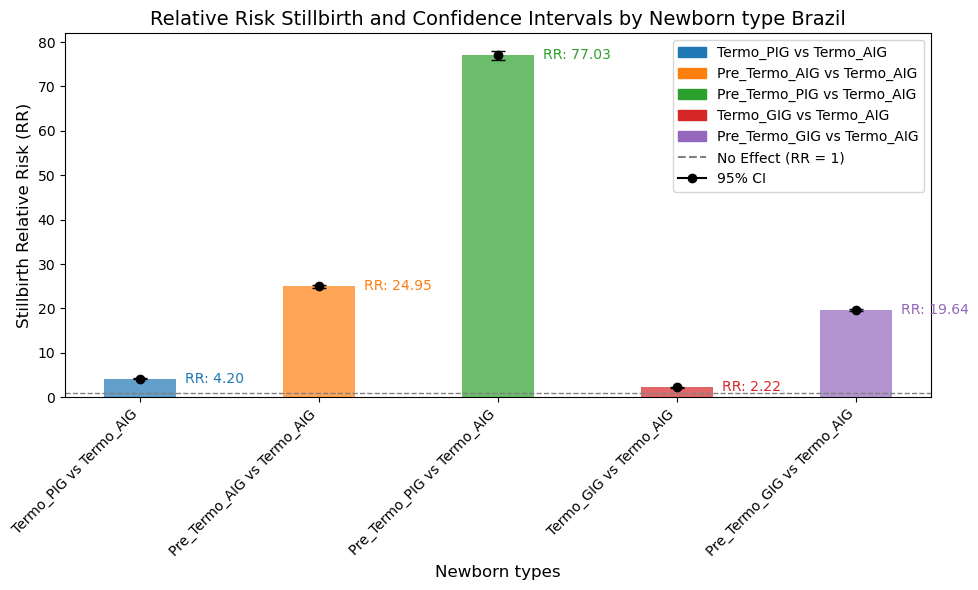

In [22]:
graf_box_plot(df=df_brasil_geral, nome_graf='./graficos/box_plot_brasil_todos_os_anos_RR_com_nasc.png', label='Brasil')

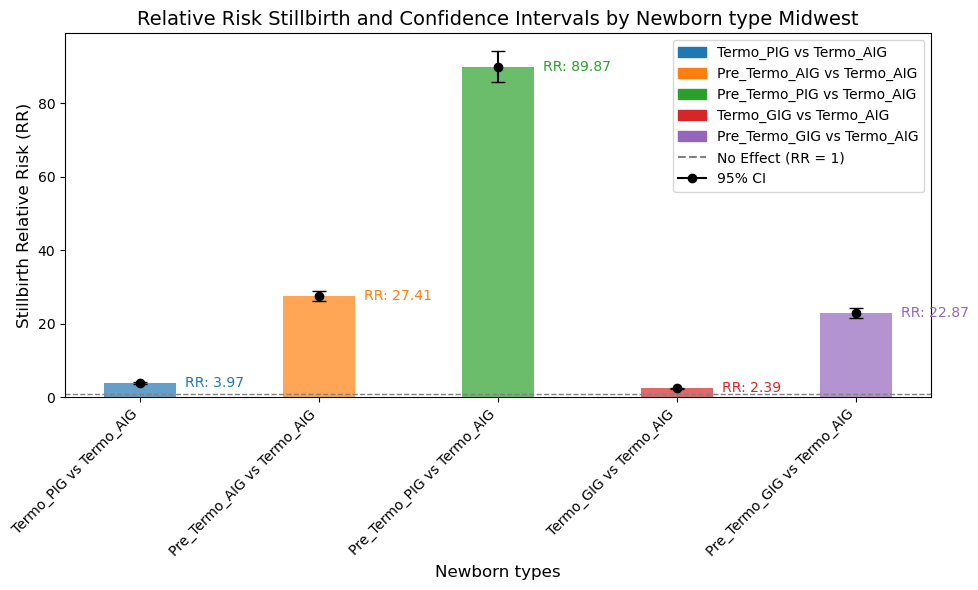

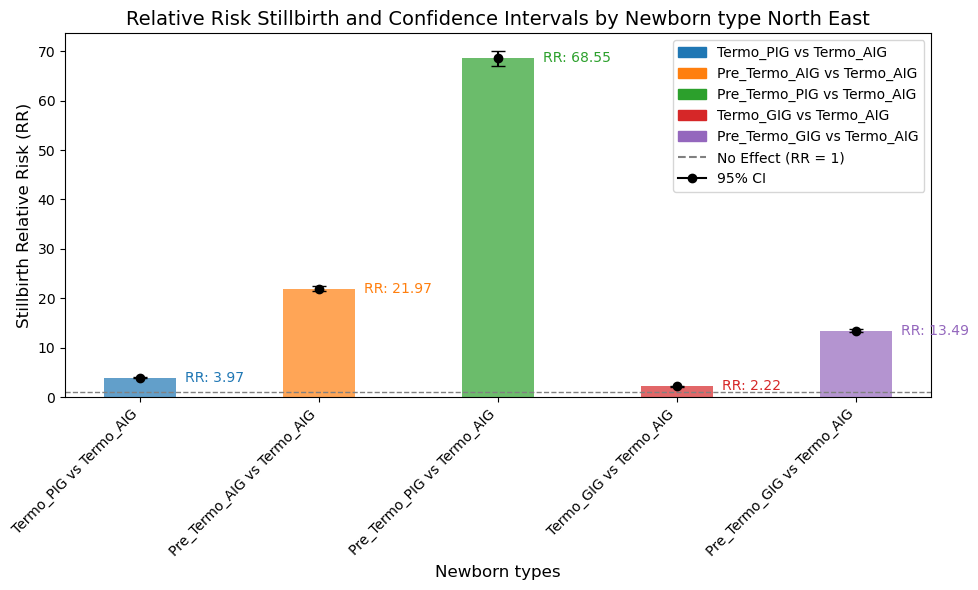

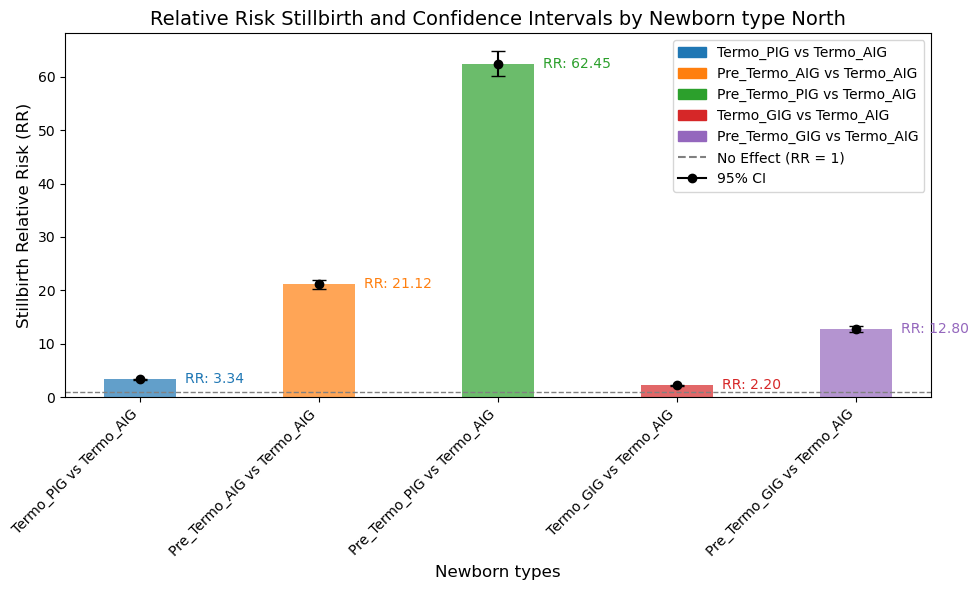

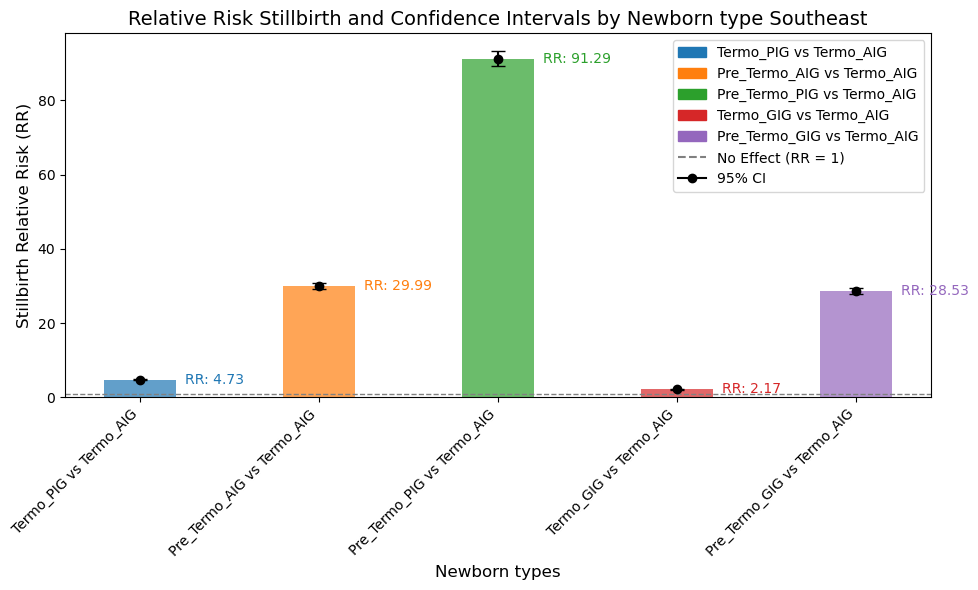

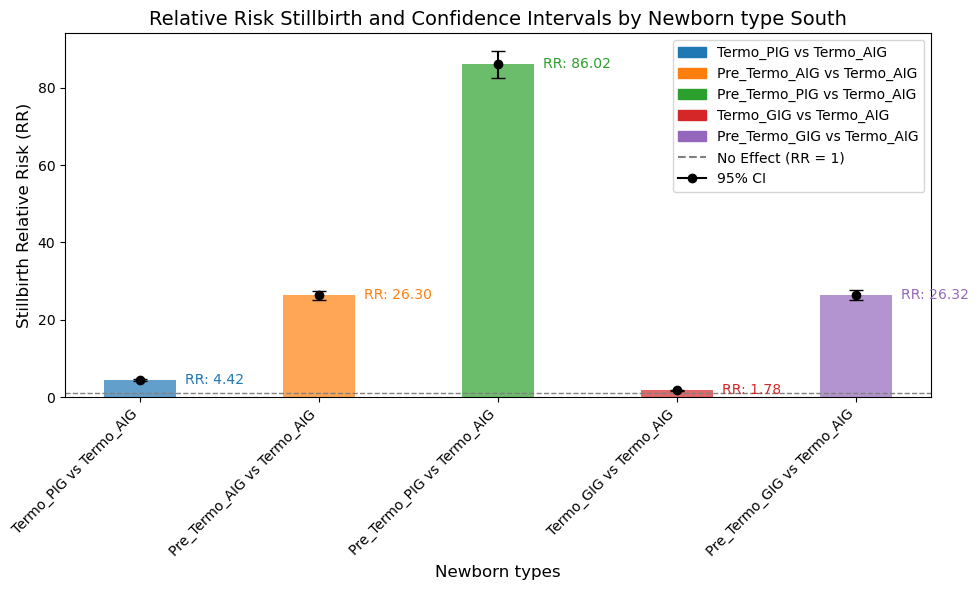

In [23]:
vet_reg = pd.unique(df_regioes_geral['Region'])
for reg in vet_reg:
    df_graf_reg = df_regioes_geral[df_regioes_geral['Region']==reg].reset_index(drop=True)
    path = f'./graficos/box_plot_{reg}_todos_os_anos_RR_com_nasc.png'
    graf_box_plot(df=df_graf_reg, nome_graf=path, label=reg)

# Cálculo ZIKA e COVID

In [25]:
df_brasil_covid_zika = calculate_rr(df_obito=df_sim_agreg_brasil_covid_zika, df_nasc=df_sinasc_agreg_brasil_covid_zika)
# Exibindo os resultados
display(df_brasil_covid_zika)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,4.24,4.14,4.33
1,Brasil,Pre_Termo_AIG vs Termo_AIG,24.52,24.06,25.00
2,Brasil,Pre_Termo_PIG vs Termo_AIG,75.53,74.13,76.95
3,Brasil,Termo_GIG vs Termo_AIG,2.25,2.17,2.32
4,Brasil,Pre_Termo_GIG vs Termo_AIG,19.06,18.65,19.48


In [26]:
df_regioes_covid_zika = pd.concat([calculate_rr(df_obito=df_sim_agreg_regiao_covid_zika, df_nasc=df_sinasc_agreg_regiao_covid_zika, region=region) for region in df_sim_agreg_regiao['ocor_REGIAO'].unique()])
display(df_regioes_covid_zika)

,Region,Comparison,RR,CI Lower,CI Upper
0,Centro-Oeste,Termo_PIG vs Termo_AIG,4.07,3.74,4.43
1,Centro-Oeste,Pre_Termo_AIG vs Termo_AIG,27.56,25.69,29.58
2,Centro-Oeste,Pre_Termo_PIG vs Termo_AIG,88.05,82.23,94.28
3,Centro-Oeste,Termo_GIG vs Termo_AIG,2.50,2.21,2.83
4,Centro-Oeste,Pre_Termo_GIG vs Termo_AIG,22.15,20.46,23.98
0,Nordeste,Termo_PIG vs Termo_AIG,4.03,3.88,4.18
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,21.79,21.09,22.51
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,67.68,65.58,69.84
3,Nordeste,Termo_GIG vs Termo_AIG,2.21,2.09,2.33
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,13.19,12.71,13.69


In [27]:
df_brasil_covid_zika.to_csv('resultado/rr_obitos_c_nasc_brasil_covid_zika.csv', index=False)
df_regioes_covid_zika.to_csv('resultado/rr_obitos_c_nasc_regiao_covid_zika.csv', index=False)

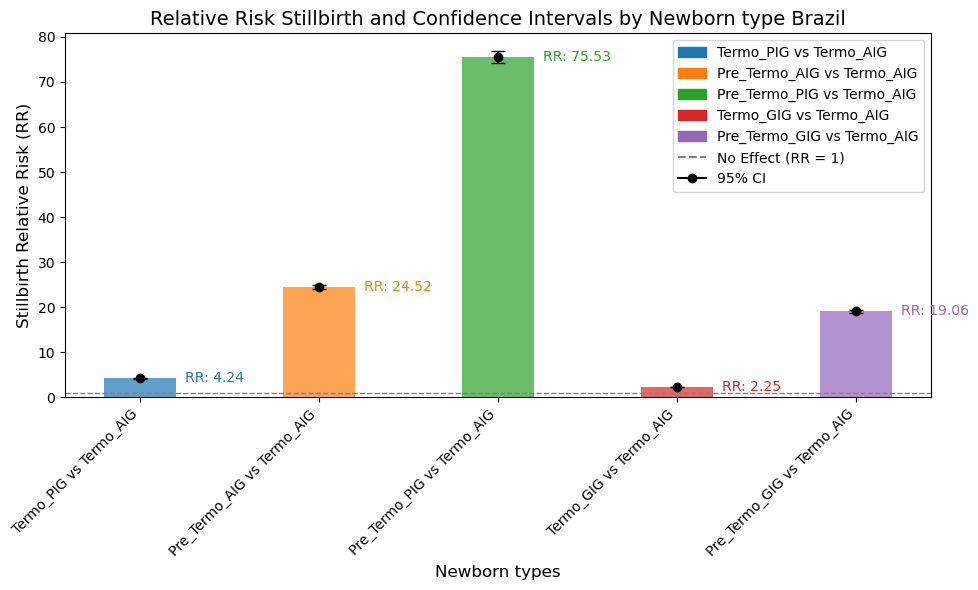

In [28]:
graf_box_plot(df_brasil_covid_zika, nome_graf='./graficos/box_plot_brasil_sem_zika_covid_os_anos_RR_com_nasc.png', label='Brasil')

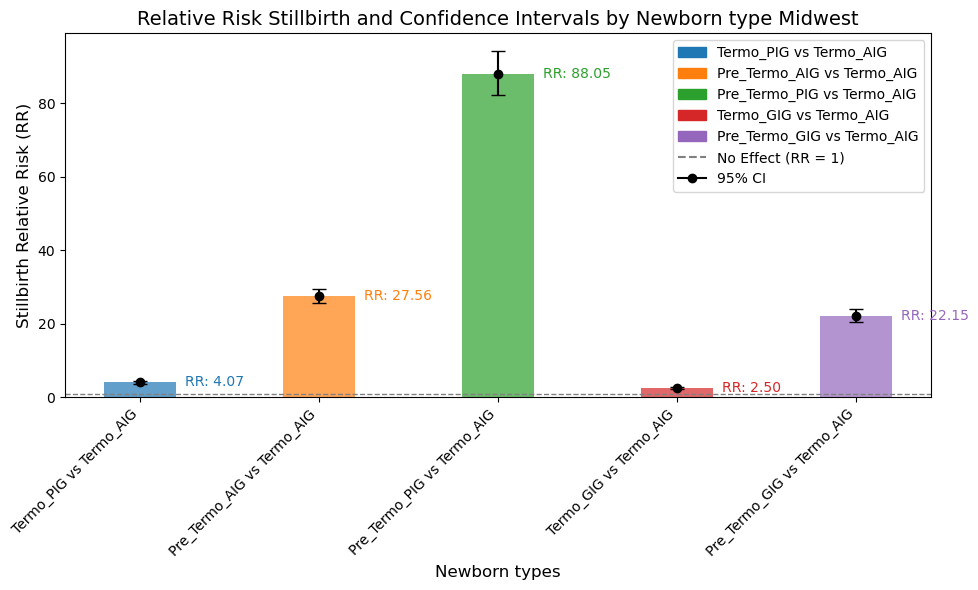

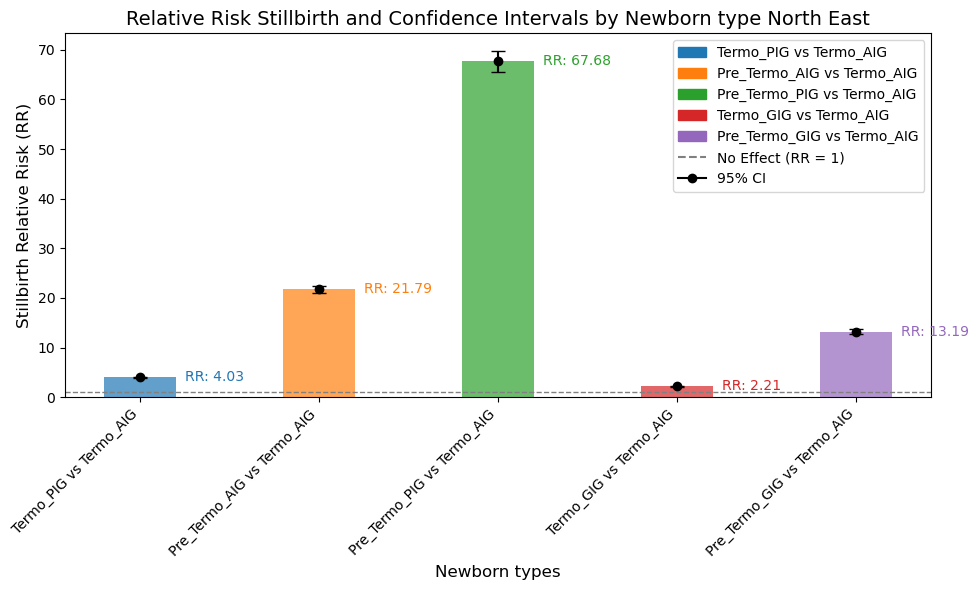

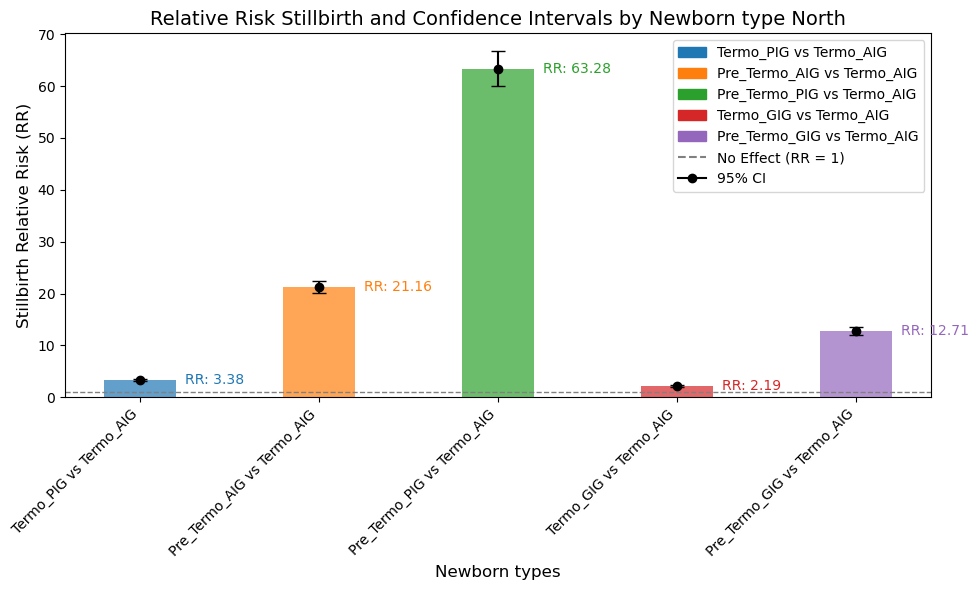

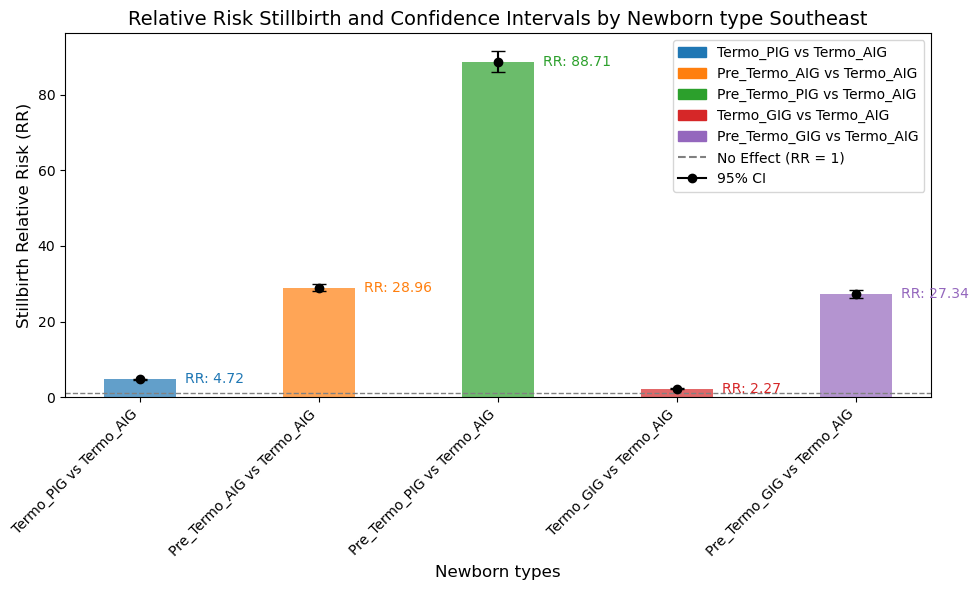

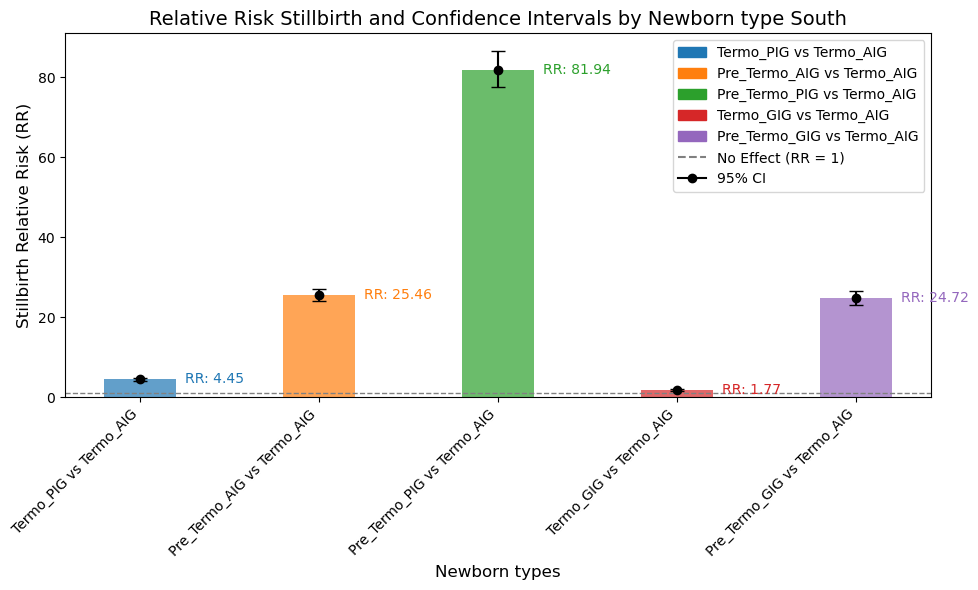

In [29]:
vet_reg = pd.unique(df_regioes_covid_zika['Region'])
for reg in vet_reg:
    df_graf_reg = df_regioes_covid_zika[df_regioes_covid_zika['Region']==reg].reset_index(drop=True)
    path = f'./graficos/box_plot_{reg}_sem_zika_covid_RR_com_nasc.png'
    graf_box_plot(df=df_graf_reg, nome_graf=path, label=reg)